## Introduction Automatic Hyperparameter Optimization with Hyperopt
Find the link to associated medium post [here](https://medium.com/@rakesh.melezhath/introduction-to-automatic-hyperparameter-optimization-with-hyperopt-e0b9c84d1059).

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from hyperopt import hp, fmin, tpe, rand, pyll, STATUS_OK, STATUS_FAIL, Trials, space_eval
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from functools import partial
import math
import zipfile
import gc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
zip_ref = zipfile.ZipFile("/content/bank-additional.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

--2020-03-18 12:00:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K   531KB/s    in 0.8s    

2020-03-18 12:00:24 (531 KB/s) - ‘bank-additional.zip’ saved [444572/444572]



In [0]:
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
int_vars = ['age', 'duration', 'campaign', 'pdays', 'previous']
float_vars = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
dtypes = {col : 'category' for col in cat_vars}
for col in int_vars:
    dtypes[col] = 'int32'
for col in float_vars:
    dtypes[col] = 'float32'

In [4]:
data = pd.read_csv("/tmp/bank-additional/bank-additional-full.csv", sep = ";", dtype=dtypes)
data.iloc[:5, :]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994003,-36.400002,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994003,-36.400002,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994003,-36.400002,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994003,-36.400002,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994003,-36.400002,4.857,5191.0,no


In [5]:
data.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [0]:
y = data['y'].copy()
data.drop(columns = ['duration', 'y'], inplace = True)

In [0]:
## The value 999 in pdays column means the client was not previously contacted. 
## We will create a new boolean column to capture this information and replace this value with nan.
data['prev_no_contact'] = (data.pdays == 999)
data.pdays[data.pdays == 999] = np.nan

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42, stratify = y)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')
del data, y

X_train: (30891, 20), y_train: (30891,), X_test: (10297, 20), y_test: (10297,)


In [0]:
# label encode categorical variables
def label_encode(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')

In [10]:
category_cols = X_test.select_dtypes(['category', 'object']).columns
category_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [11]:
for col in category_cols:
    label_encode(col,train=X_train,test=X_test,verbose=True)

job , marital , education , default , housing , loan , contact , month , day_of_week , poutcome , 

In [0]:
# We will also do label encoding for the target variable:
lbl_enc = LabelEncoder()
y_train = lbl_enc.fit_transform(y_train)
y_test = lbl_enc.transform(y_test)

## XGBoost Model

In [0]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [0]:
param = {'max_depth': 8, 'eta': 0.3, 'objective': 'binary:logistic', 'seed': 100}
param['eval_metric'] = ['auc']
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 50

In [15]:
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.799226	train-auc:0.79498
[1]	eval-auc:0.809382	train-auc:0.808672
[2]	eval-auc:0.811315	train-auc:0.811323
[3]	eval-auc:0.813018	train-auc:0.813588
[4]	eval-auc:0.816314	train-auc:0.819951
[5]	eval-auc:0.815756	train-auc:0.828811
[6]	eval-auc:0.814274	train-auc:0.834134
[7]	eval-auc:0.813671	train-auc:0.843976
[8]	eval-auc:0.811256	train-auc:0.84968
[9]	eval-auc:0.813116	train-auc:0.852202
[10]	eval-auc:0.812495	train-auc:0.855752
[11]	eval-auc:0.812375	train-auc:0.861677
[12]	eval-auc:0.81238	train-auc:0.864285
[13]	eval-auc:0.811846	train-auc:0.866293
[14]	eval-auc:0.811861	train-auc:0.870137
[15]	eval-auc:0.812436	train-auc:0.870432
[16]	eval-auc:0.812327	train-auc:0.872658
[17]	eval-auc:0.811928	train-auc:0.874695
[18]	eval-auc:0.812027	train-auc:0.874663
[19]	eval-auc:0.811827	train-auc:0.874949
[20]	eval-auc:0.810212	train-auc:0.881693
[21]	eval-auc:0.809793	train-auc:0.884086
[22]	eval-auc:0.809268	train-auc:0.886429
[23]	eval-auc:0.809705	train-auc:0.886857
[24]	

In [16]:
print(f"ROC AUC: {roc_auc_score(y_test, bst.predict(dtest))}")

ROC AUC: 0.8008125356168365


## Hyperparameter optimization with Hyperopt
Write a function that accepts a given set of hyperparameters and returns roc-auc score on validation dataset. We will return -ve of roc_auc as hyperopt can only minimize the function.

In [0]:
default_params = {'num_round': 100,
                  'eval_metric': ['auc'],
                  #'evallist': [(dtrain, 'train')] - Commented out as we do not want intermediate output to be printed out
                  'objective': 'binary:logistic',
                  'seed': 100}
def hyperopt_xgb_train(params):
    params = {**default_params, **params}
    num_round = params['num_round']
    if 'evallist' in params.keys():
        evallist = params['evallist']
        del params['evallist']
    else:
        evallist = () #default value
    del params['num_round']
    bst = xgb.train(params, dtrain, num_round, evals = evallist)
    return_dict = {'loss': -roc_auc_score(y_test, bst.predict(dtest)),
                   'status': STATUS_OK
                   }
    print(return_dict)
    return return_dict

In [18]:
hyperopt_xgb_train({'max_depth': 8, 'eta': 0.3, 'num_round': 50})

{'loss': -0.8008125356168365, 'status': 'ok'}


{'loss': -0.8008125356168365, 'status': 'ok'}

## Hyperparameter Plotting functions
Note that these functions does not work with nested choice type hyperparameter.

In [0]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_params_space(p_space, n_samples=500, **kwargs):
    """
    Plots the parameter space defined.
    p_space: Hyperopt parameter space.
    n_samples: Number of samples to make the plot. Default = 500.
    params: Parameters to be plotted. Default = All parameters in p_space.
    ncols: Number of columns in the figure. Default = 3
    figsize: Figure size. Default = (15, 5*nrows).
    constrained_layout: Constrained layout. Default = True.
    """
    defaults = {'params': p_space.keys(), 'ncols': 3, 'constrained_layout': True}
    defaults = {k:v for k,v in defaults.items() if k not in kwargs}
    kwargs = {**kwargs, **defaults}
    params = kwargs['params']
    del kwargs['params']
    nrows = int(math.ceil(len(params)/kwargs['ncols']))
    if 'figsize' not in kwargs.keys():
        kwargs['figsize'] = (15, 5*nrows)
    f, axs = plt.subplots(nrows=nrows, **kwargs)
    axs = trim_axs(axs, len(params))
    f.suptitle('Prior Parameter Space')
    for ax, p in zip(axs, params):
        xs = np.array([pyll.stochastic.sample(p_space)[p] for _ in range(n_samples)])
        if pd.api.types.is_bool_dtype(xs) or pd.api.types.is_string_dtype(xs):
            sns.countplot(xs, ax = ax)
        else:
            sns.distplot(xs, ax = ax)
        ax.set_title(p)

def plot_params_tried(p_space, trials, dist_plots=True, **kwargs):
    """
    Plots the parameters tried by hyperopt.
    p_space: Hyperopt parameter space.
    trials: Hyperopt trials object.
    dist_plots: If True, plots the distribution of values tried for each parameter. 
    If False, plots a scatter plot of loss vs parameter values. Default True.
    params: Parameters to be plotted. Default = All parameters in p_space.
    ncols: Number of columns in the figure. Default = 3
    figsize: Figure size. Default = (15, 5*nrows).
    constrained_layout: Constrained layout. Default = True.
    """
    defaults = {'params': p_space.keys(), 'ncols': 3, 'constrained_layout': True}
    defaults = {k:v for k,v in defaults.items() if k not in kwargs}
    kwargs = {**kwargs, **defaults}
    params = kwargs['params']
    del kwargs['params']
    results_df = pd.DataFrame(columns = ['tid', *params, 'loss', 'status'])
    for t in trials.trials:
        result_dict = t['misc']['vals']
        result_dict = {d:v[0] for d,v in result_dict.items()}
        result_dict = space_eval(p_space, result_dict)
        result_dict['tid'] = t['tid']
        result_dict.update(t['result'])
        results_df = pd.concat([results_df, pd.DataFrame(result_dict, index = [0])], 
                               axis = 0, 
                               ignore_index = True)
    results_df = results_df[results_df.status == 'ok']
    results_df = results_df.infer_objects()
    nrows = int(math.ceil((len(params)+1)/kwargs['ncols']))
    if 'figsize' not in kwargs.keys():
        kwargs['figsize'] = (15, 5*nrows)
    f, axs = plt.subplots(nrows=nrows, **kwargs)
    axs = trim_axs(axs, len(params)+1)
    f.suptitle('Parameter Space tried by Hyperopt & Loss')
    for ax, p in zip(axs, [*params, 'loss']):
        if p == 'loss':
            sns.scatterplot(x=results_df.tid, y = results_df.loc[:, p], alpha = 0.8, ax = ax)
            ax.set_title('Scatterplot of Loss vs trial number.')
        elif dist_plots:
            if pd.api.types.is_bool_dtype(results_df.loc[:, p]) or pd.api.types.is_string_dtype(results_df.loc[:, p]):
                sns.countplot(results_df.loc[:, p], ax = ax)
            else:
                sns.distplot(results_df.loc[:, p].astype('float'), bins=10, ax = ax)
            ax.set_title(p)
        else:
            sns.scatterplot(x=results_df.loc[:, p], y=results_df.loss, alpha = 0.8, ax = ax)
            ax.set_title(f'{p} vs loss')
    return results_df

## Define configuration space for XGB model

In [0]:
space4xgb = {
    'eta': hp.uniform('eta', 0.0001, 0.5),
    'max_depth': pyll.scope.int(hp.quniform('max_depth', 1, 16, 1)),
    'subsample': hp.uniform('subsample', 0.3, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.3, 1),
}

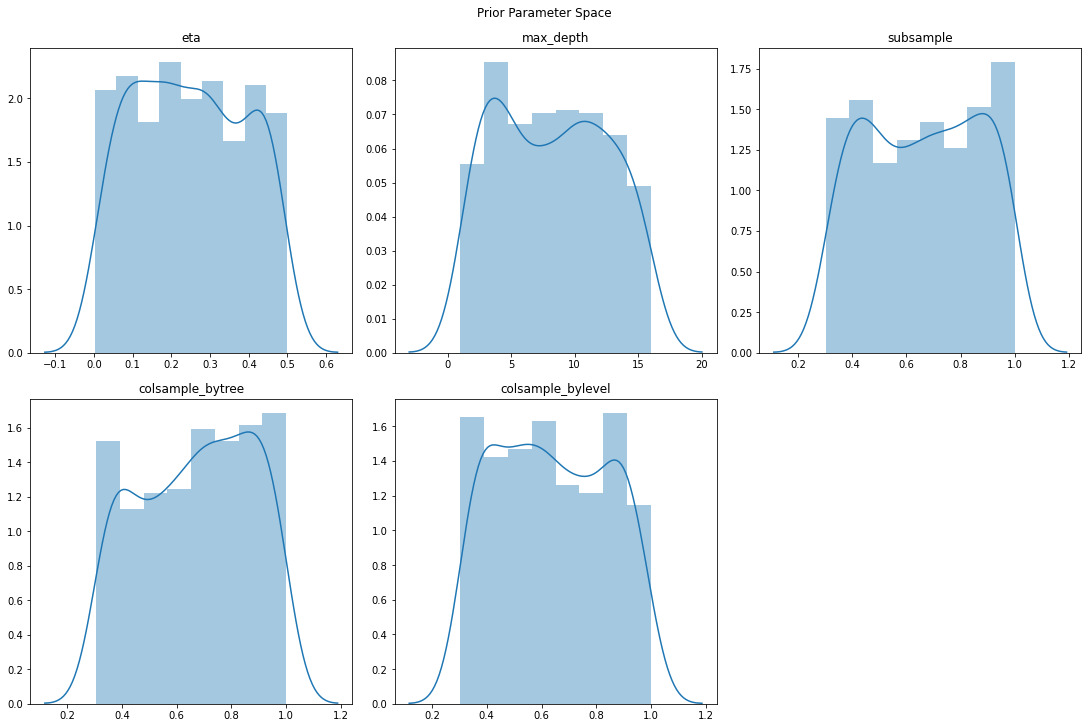

In [21]:
#Code to test the configuration space: 
plot_params_space(space4xgb)

In [22]:
trials = Trials()
best = fmin(hyperopt_xgb_train, space4xgb, algo=tpe.suggest, max_evals=500, trials=trials)

{'loss': -0.8164689421186311, 'status': 'ok'}
{'loss': -0.8101365044740407, 'status': 'ok'}
{'loss': -0.7862130292520371, 'status': 'ok'}
{'loss': -0.8124427771886193, 'status': 'ok'}
{'loss': -0.8130433100731018, 'status': 'ok'}
{'loss': -0.7878795198001307, 'status': 'ok'}
{'loss': -0.7376180780683316, 'status': 'ok'}
{'loss': -0.781206387065852, 'status': 'ok'}
{'loss': -0.7497600698939136, 'status': 'ok'}
{'loss': -0.7890461952727259, 'status': 'ok'}
{'loss': -0.814390569982602, 'status': 'ok'}
{'loss': -0.8011438901322021, 'status': 'ok'}
{'loss': -0.8147159333215084, 'status': 'ok'}
{'loss': -0.7544468209968563, 'status': 'ok'}
{'loss': -0.7611099998867809, 'status': 'ok'}
{'loss': -0.7638989161159816, 'status': 'ok'}
{'loss': -0.8143295732017979, 'status': 'ok'}
{'loss': -0.8016577632438022, 'status': 'ok'}
{'loss': -0.7394211863095485, 'status': 'ok'}
{'loss': -0.7663352020771927, 'status': 'ok'}
{'loss': -0.8142668781347534, 'status': 'ok'}
{'loss': -0.8035125276915006, 'statu

In [23]:
# space_eval is required as best has interger indices for choice parameters.
print(f'best: {space_eval(space4xgb, best)}')

best: {'colsample_bylevel': 0.6643675664230413, 'colsample_bytree': 0.43341880024506274, 'eta': 0.13025880756623717, 'max_depth': 5, 'subsample': 0.953677630165892}


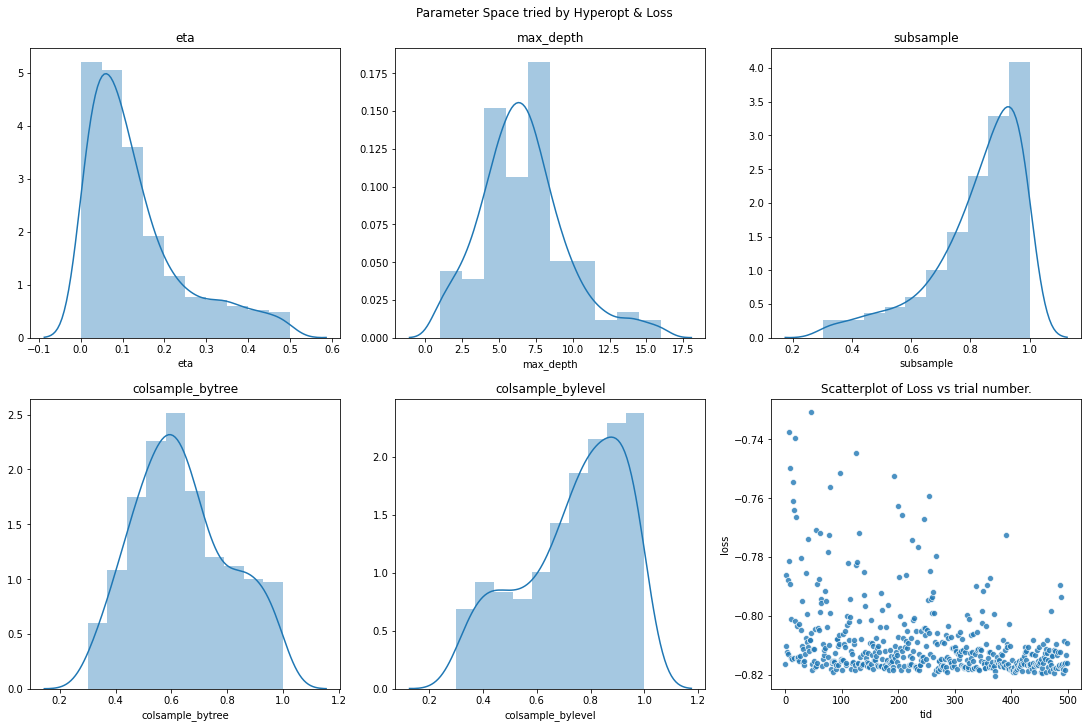

In [24]:
## Code to plot the hyperopt results:
results_df = plot_params_tried(space4xgb, trials, dist_plots=True)

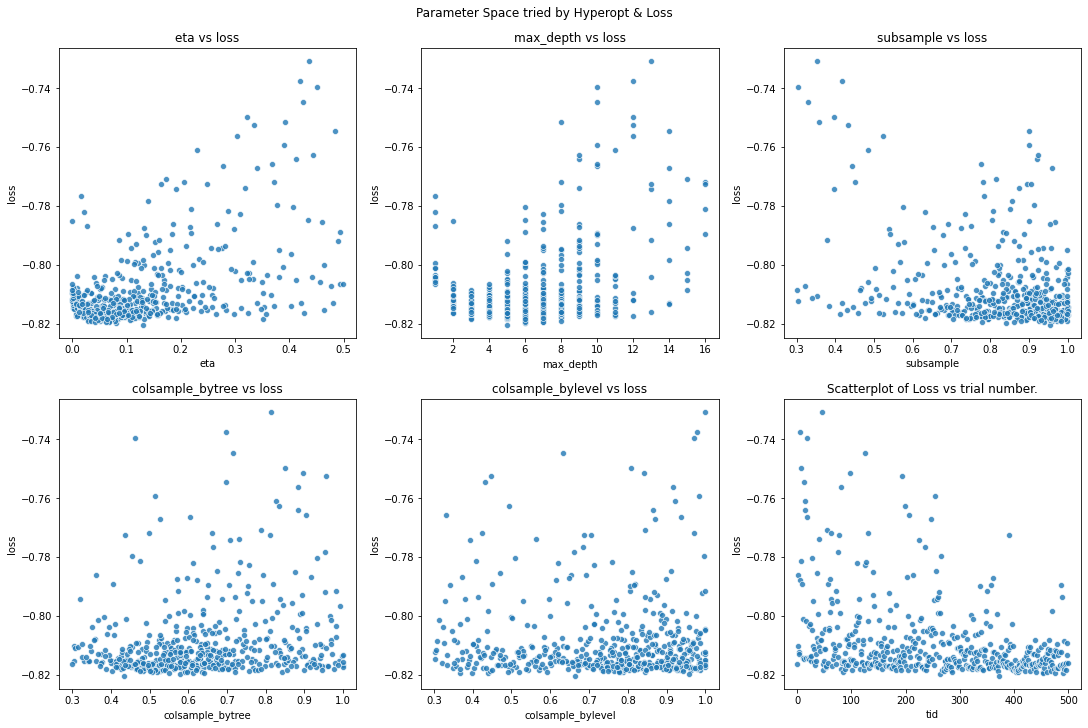

In [25]:
## Code to plot the hyperopt results:
results_df = plot_params_tried(space4xgb, trials, dist_plots=False)

In [35]:
params = {**default_params, **space_eval(space4xgb, best)}
params

{'colsample_bylevel': 0.6643675664230413,
 'colsample_bytree': 0.43341880024506274,
 'eta': 0.13025880756623717,
 'eval_metric': ['auc'],
 'max_depth': 5,
 'num_round': 100,
 'objective': 'binary:logistic',
 'seed': 100,
 'subsample': 0.953677630165892}

In [36]:
params['num_round'] = params['num_round'] * 10
params

{'colsample_bylevel': 0.6643675664230413,
 'colsample_bytree': 0.43341880024506274,
 'eta': 0.13025880756623717,
 'eval_metric': ['auc'],
 'max_depth': 5,
 'num_round': 1000,
 'objective': 'binary:logistic',
 'seed': 100,
 'subsample': 0.953677630165892}

In [37]:
num_round = params.pop('num_round')
evallist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(params, dtrain, num_round, evals = evallist, early_stopping_rounds=50)

[0]	train-auc:0.775591	eval-auc:0.783235
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.784508	eval-auc:0.79807
[2]	train-auc:0.785349	eval-auc:0.798516
[3]	train-auc:0.785831	eval-auc:0.799572
[4]	train-auc:0.791062	eval-auc:0.802176
[5]	train-auc:0.791976	eval-auc:0.802741
[6]	train-auc:0.792703	eval-auc:0.805367
[7]	train-auc:0.793345	eval-auc:0.806602
[8]	train-auc:0.79419	eval-auc:0.808551
[9]	train-auc:0.795093	eval-auc:0.808585
[10]	train-auc:0.795869	eval-auc:0.808581
[11]	train-auc:0.796006	eval-auc:0.808501
[12]	train-auc:0.799512	eval-auc:0.80986
[13]	train-auc:0.799477	eval-auc:0.809029
[14]	train-auc:0.800654	eval-auc:0.8096
[15]	train-auc:0.801352	eval-auc:0.810278
[16]	train-auc:0.803435	eval-auc:0.810937
[17]	train-auc:0.805136	eval-auc:0.812169
[18]	train-auc:0.805502	eval-auc:0.811516
[19]	train-auc:0.80567	eval-auc:0.812073
[20]	train-auc:0.80683	eval-auc:0.8

In [38]:
print(f'Best Score: {bst.best_score}')
print(f'Best Iteration: {bst.best_iteration}')
print(f'Best n_tree_limit: {bst.best_ntree_limit}')

Best Score: 0.820565
Best Iteration: 97
Best n_tree_limit: 98


In [39]:
print(f"ROC AUC: {roc_auc_score(y_test, bst.predict(dtest, ntree_limit=bst.best_ntree_limit))}")

ROC AUC: 0.8205653972291517


### Nested Configuration Space
Let's perform the optimization for xgboost and random forest models together to select the best performing model. We will give 60% preference to xgboost model and 40% to random forest model.

In [0]:
space4nested = hp.pchoice('classifier_type',
                          [(0.6, {'type': 'xgboost',
                                  'eta': hp.uniform('eta', 0.0001, 0.5),
                                  'max_depth': pyll.scope.int(hp.quniform('max_depth', 1, 16, 1)),
                                  'subsample': hp.uniform('subsample', 0.3, 1),
                                  'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
                                  'colsample_bylevel': hp.uniform('colsample_bylevel', 0.3, 1)
                                  }
                            ),
                           (0.4, {'type': 'random forest',
                                  'min_samples_leaf': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('min_samples_leaf', 2, 1.2, 1), 1)),
                                  'max_features': hp.choice('max_features', [1.0, 0.5, 'sqrt', 'log2'])
                                  }
                            )]
                          )

In [68]:
#Let's draw a few samples to see what we get from this nested configuration 
for _ in range(5):
    print(pyll.stochastic.sample(space4nested))

{'colsample_bylevel': 0.4088517138461724, 'colsample_bytree': 0.5234901180300545, 'eta': 0.2320023776214054, 'max_depth': 4, 'subsample': 0.3057427635487774, 'type': 'xgboost'}
{'colsample_bylevel': 0.6633093209581726, 'colsample_bytree': 0.40804161139808454, 'eta': 0.04542759320918589, 'max_depth': 10, 'subsample': 0.730021976084508, 'type': 'xgboost'}
{'max_features': 1.0, 'min_samples_leaf': 1, 'type': 'random forest'}
{'colsample_bylevel': 0.9293749971498881, 'colsample_bytree': 0.5930396138661698, 'eta': 0.04536487550924646, 'max_depth': 4, 'subsample': 0.5545290568390197, 'type': 'xgboost'}
{'max_features': 1.0, 'min_samples_leaf': 10, 'type': 'random forest'}


In [0]:
from sklearn.ensemble import RandomForestClassifier
# Filling missing values in pdays column with median for random forest model.
X_train.pdays.fillna(np.nanmedian(X_train.pdays), inplace = True)
X_test.pdays.fillna(np.nanmedian(X_train.pdays), inplace = True)

In [0]:
## Objective function:
xgb_defaults = {'num_round': 100,
                'eval_metric': ['auc'],
                'objective': 'binary:logistic',
                'seed': 100}
rf_defaults = {'n_jobs': -1,
               'n_estimators': 100,
               'random_state': 100}

def hyperopt_xgb_nested(params):
    model_type = params.pop('type')
    if model_type == 'xgboost':
        params = {**xgb_defaults, **params}
        num_round = params['num_round']
        del params['num_round']
        if 'evallist' in params.keys():
            evallist = params['evallist']
            del params['evallist']
        else:
            evallist = () #default value
        bst = xgb.train(params, dtrain, num_round, evals = evallist)
        return_dict = {'loss': -roc_auc_score(y_test, bst.predict(dtest)),
                       'status': STATUS_OK}
    else:
        params = {**rf_defaults, **params}
        rf_model = RandomForestClassifier(**params)
        rf_model.fit(X_train, y_train)
        return_dict = {'loss': -roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]),
                       'status': STATUS_OK}
    return return_dict

In [70]:
trials = Trials()
best = fmin(hyperopt_xgb_nested, space4nested, algo=tpe.suggest, max_evals=1000, trials=trials)

100%|██████████| 1000/1000 [35:46<00:00,  2.43s/it, best loss: -0.8211672510029323]


In [71]:
# space_eval is required as best has interger indices for choice parameters.
print(f'best: {space_eval(space4nested, best)}')

best: {'colsample_bylevel': 0.3528394338140982, 'colsample_bytree': 0.5832849804672391, 'eta': 0.04786811755722358, 'max_depth': 8, 'subsample': 0.823532008147221, 'type': 'xgboost'}


In [73]:
trials.trials

[{'book_time': datetime.datetime(2020, 3, 18, 15, 55, 13, 410000),
  'exp_key': None,
  'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'idxs': {'classifier_type': [0],
    'colsample_bylevel': [0],
    'colsample_bytree': [0],
    'eta': [0],
    'max_depth': [0],
    'max_features': [],
    'min_samples_leaf': [],
    'subsample': [0]},
   'tid': 0,
   'vals': {'classifier_type': [0],
    'colsample_bylevel': [0.7054252589391881],
    'colsample_bytree': [0.44472286954595813],
    'eta': [0.1496073113541443],
    'max_depth': [14.0],
    'max_features': [],
    'min_samples_leaf': [],
    'subsample': [0.5006522453586967]},
   'workdir': None},
  'owner': None,
  'refresh_time': datetime.datetime(2020, 3, 18, 15, 55, 17, 359000),
  'result': {'loss': -0.7864421563706491, 'status': 'ok'},
  'spec': None,
  'state': 2,
  'tid': 0,
  'version': 0},
 {'book_time': datetime.datetime(2020, 3, 18, 15, 55, 17, 366000),
  'exp_key': None,
  'misc': {'cmd': ('domain_attachment', '